In [ ]:
import io
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_text
import plotly.graph_objects as go
import seaborn as sns
import os
import shutil
import matplotlib
import re

#Juntar os arquivos

In [ ]:
# Fazer upload dos arquivos CSV
arquivos_upload = files.upload()

# Lista para armazenar os DataFrames de cada arquivo CSV
dfs = []

# Iterar sobre os arquivos carregados
for nome_arquivo, conteudo_arquivo in arquivos_upload.items():
    # Ler o arquivo CSV e adicionar ao DataFrame
    df = pd.read_csv(io.BytesIO(conteudo_arquivo), sep=";")
    dfs.append(df)

df_00_25, df_00_50, df_00_75 = [],[],[]
df_10_25, df_10_50, df_10_75 = [],[],[]
df_01, df_11, df_full  = [],[],[]

#['Identifier','State', 'Qubit', 'Uniform State', 'Dense State', 'Sparsity','Duration','Output Qubit','Output CNot Gate','Output Width', 'Output Depth', 'Preparation Method']

for data in dfs:
  if (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.25):
    df_00_25 = data
  elif (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.5):
    df_00_50 = data
  elif (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.75):
    df_00_75 = data

  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.25):
    df_10_25 = data
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.5):
    df_10_50 = data
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 0 and data.loc[0,'Sparsity'] == 0.75):
    df_10_75 = data

  elif (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 1 and data.loc[0,'Sparsity'] == 0):
    df_01 = data
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 1 and data.loc[0,'Sparsity'] == 0):
    df_11 = data

# Concatenar os DataFrames
df_full = pd.concat(dfs, ignore_index=True)
dfs = df_00_25, df_00_50, df_00_75, df_10_25, df_10_50, df_10_75, df_01, df_11
del df

Saving raw_DensoNaoUniformedataset.csv to raw_DensoNaoUniformedataset.csv
Saving raw_DensoUniformedataset.csv to raw_DensoUniformedataset.csv
Saving raw_EsparsoNaoUniforme25dataset.csv to raw_EsparsoNaoUniforme25dataset.csv
Saving raw_EsparsoNaoUniforme50dataset.csv to raw_EsparsoNaoUniforme50dataset.csv
Saving raw_EsparsoNaoUniforme75dataset.csv to raw_EsparsoNaoUniforme75dataset.csv
Saving raw_EsparsoUniforme25dataset.csv to raw_EsparsoUniforme25dataset.csv
Saving raw_EsparsoUniforme50dataset.csv to raw_EsparsoUniforme50dataset.csv
Saving raw_EsparsoUniforme75dataset.csv to raw_EsparsoUniforme75dataset.csv


#Pre processamento

In [ ]:
def nomear(data):
    estado_mapping = {
        (0, 0, 0.25): 'Não Uniforme Esparso - 25%',
        (0, 0, 0.5): 'Não Uniforme Esparso - 50%',
        (0, 0, 0.75): 'Não Uniforme Esparso - 75%',
        (1, 0, 0.25): 'Uniforme Esparso - 25%',
        (1, 0, 0.5): 'Uniforme Esparso - 50%',
        (1, 0, 0.75): 'Uniforme Esparso - 75%',
        (0, 1, 0): 'Não Uniforme Denso',
        (1, 1, 0): 'Uniforme Denso'
    }

    # Iterar sobre todas as linhas do DataFrame
    for index, row in data.iterrows():
        # Obtém os valores relevantes da linha atual
        uniform_state = row['Uniform State']
        dense_state = row['Dense State']
        sparsity = row['Sparsity']

        # Obtém o tipo de estado com base nos valores da linha atual
        state_type = estado_mapping.get((uniform_state, dense_state, sparsity), None)

        # Define o valor da nova coluna 'StateType' para a linha atual
        data.at[index, 'StateType'] = state_type

    return data


#Análise do conjunto de dados

In [ ]:
# Criar um diretório temporário para salvar as figuras
temp_dir = "./temp_figures/"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Plotar e salvar cada figura
figuras=[]

In [ ]:
# Cabeçalhos dos comentários
columns_cont_qubit = ['StateType', 'Qubit', 'Output CNot Gate', 'Preparation Method']
columns_depth_qubit = ['StateType', 'Qubit', 'Output Depth', 'Preparation Method']
columns_duration_qubit = ['StateType', 'Qubit', 'Duration', 'Preparation Method']
columns_width_qubit = ['StateType', 'Qubit', 'Output Width', 'Preparation Method']

# Criar DataFrames vazios com cabeçalhos
df_table_cont_qubit = pd.DataFrame(columns=columns_cont_qubit)
df_table_depth_qubit = pd.DataFrame(columns=columns_depth_qubit)
df_table_duration_qubit = pd.DataFrame(columns=columns_duration_qubit)
df_table_width_qubit = pd.DataFrame(columns=columns_width_qubit)

df_full = nomear(df_full)

# Agrupar por 'Preparation Method' e 'Qubit' e calcular a média
df_table_cont_qubit = df_full.groupby(['StateType', 'Preparation Method', 'Qubit']).agg({'Output CNot Gate': 'mean'}).reset_index()
#df_table_cont_qubit['Output CNot Gate'] = df_table_cont_qubit['Output CNot Gate'].round().astype(int)

df_table_depth_qubit = df_full.groupby(['Preparation Method', 'Qubit', 'StateType']).agg({'Output Depth': 'mean'}).reset_index()
df_table_duration_qubit = df_full.groupby(['Preparation Method', 'Qubit', 'StateType']).agg({'Duration': 'mean'}).reset_index()
df_table_width_qubit = df_full.groupby(['Preparation Method', 'Qubit', 'StateType']).agg({'Output Width': 'mean'}).reset_index()

# Concatenar os DataFrames horizontalmente por 'Preparation Method' e 'Qubit' e 'StateType'
merged_df = pd.merge(df_table_cont_qubit, df_table_depth_qubit, on=['StateType', 'Qubit', 'Preparation Method'], how='outer')
merged_df = pd.merge(merged_df, df_table_duration_qubit, on=['StateType', 'Qubit', 'Preparation Method'], how='outer')
merged_df = pd.merge(merged_df, df_table_width_qubit, on=['StateType', 'Qubit', 'Preparation Method'], how='outer')

Geração de gráficos

In [ ]:
def cont_qubit(df, titulo):
  # Agrupar por 'Preparation Method' e 'Qubit' e calcular a média do 'Output CNot Gate'
  df_media = df.groupby(['Preparation Method', 'Qubit']).agg({'Output CNot Gate': 'mean'}).reset_index()

  #df_media.head()

  # Cores personalizadas
  cores = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'yellow']

  # Criar o gráfico de linha
  fig = plt.figure(figsize=(10, 6))

  # Iterar sobre os métodos de preparação únicos
  for i, metodo in enumerate(df_media['Preparation Method'].unique()):
      # Filtrar os dados para o método de preparação atual
      dados_metodo = df_media[df_media['Preparation Method'] == metodo]
      # Plotar a linha para o método de preparação atual
      plt.plot(dados_metodo['Qubit'], dados_metodo['Output CNot Gate'], marker='o', label=metodo, color=cores[i])

  # Adicionar rótulos aos eixos e título do gráfico
  plt.xlabel('Número de Qubits')
  plt.ylabel('Número de CNOTs')
  plt.title(f'Comparação do Número de CNOTs por Número de Qubits\n para Métodos de Preparação ({titulo})')
  plt.legend()  # Adicionar legenda
  plt.grid(True)  # Adicionar grade

  return figuras.append(fig)


In [ ]:
def depth_qubit(df, titulo):
  # Agrupar por 'Preparation Method' e 'Qubit' e calcular a média do 'Output Depth'
  df_media = df.groupby(['Preparation Method', 'Qubit']).agg({'Output Depth': 'mean'}).reset_index()

  # Cores personalizadas
  cores = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'yellow']

  # Criar o gráfico de linha
  fig = plt.figure(figsize=(10, 6))

  # Iterar sobre os métodos de preparação únicos
  for i, metodo in enumerate(df_media['Preparation Method'].unique()):
      # Filtrar os dados para o método de preparação atual
      dados_metodo = df_media[df_media['Preparation Method'] == metodo]
      # Plotar a linha para o método de preparação atual
      plt.plot(dados_metodo['Qubit'], dados_metodo['Output Depth'], marker='o', label=metodo, color=cores[i])



  # Adicionar rótulos aos eixos e título do gráfico
  plt.xlabel('Número de Qubits')
  plt.ylabel('Profundidade')
  plt.title(f'Comparação da Profundidade por Número de Qubits\n para Métodos de Preparação ({titulo})')
  plt.legend()  # Adicionar legenda
  plt.grid(True)  # Adicionar grade



  return figuras.append(fig)


In [ ]:
def duration_qubit(df, titulo):
  # Agrupar por 'Preparation Method' e 'Qubit' e calcular a média do 'Duration'
  df_media = df.groupby(['Preparation Method', 'Qubit']).agg({'Duration': 'mean'}).reset_index()

  # Cores personalizadas
  cores = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'yellow']

  # Criar o gráfico de linha
  fig = plt.figure(figsize=(10, 6))

  # Iterar sobre os métodos de preparação únicos
  for i, metodo in enumerate(df_media['Preparation Method'].unique()):
      # Filtrar os dados para o método de preparação atual
      dados_metodo = df_media[df_media['Preparation Method'] == metodo]
      # Plotar a linha para o método de preparação atual
      plt.plot(dados_metodo['Qubit'], dados_metodo['Duration'], marker='o', label=metodo, color=cores[i])



  # Adicionar rótulos aos eixos e título do gráfico
  plt.xlabel('Número de Qubits')
  plt.ylabel('Duração')
  plt.title(f'Comparação da Duração (em microssegundos) por Número de Qubits\n para Métodos de Preparação ({titulo})')
  plt.legend()  # Adicionar legenda
  plt.grid(True)  # Adicionar grade



  return figuras.append(fig)


In [ ]:
def width_qubit(df, titulo):
  # Agrupar por 'Preparation Method' e 'Qubit' e calcular a média do 'Output Width'
  df_media = df.groupby(['Preparation Method', 'Qubit']).agg({'Output Width': 'mean'}).reset_index()

  # Cores personalizadas
  cores = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'yellow']

  # Criar o gráfico de linha
  fig = plt.figure(figsize=(10, 6))

  # Iterar sobre os métodos de preparação únicos
  for i, metodo in enumerate(df_media['Preparation Method'].unique()):
      # Filtrar os dados para o método de preparação atual
      dados_metodo = df_media[df_media['Preparation Method'] == metodo]
      # Plotar a linha para o método de preparação atual
      plt.plot(dados_metodo['Qubit'], dados_metodo['Output Width'], marker='o', label=metodo, color=cores[i])



  # Adicionar rótulos aos eixos e título do gráfico
  plt.xlabel('Número de Qubits')
  plt.ylabel('Largura')
  plt.title(f'Comparação da Largura por Número de Qubits para Métodos\n de Preparação ({titulo})')
  plt.legend()  # Adicionar legenda
  plt.grid(True)  # Adicionar grade


  return figuras.append(fig)

In [ ]:
def gerarFigs(df):
    df = nomear(df)
    titulo = df.loc[0, 'StateType']
    cont_qubit(df, titulo)
    depth_qubit(df, titulo)
    duration_qubit(df, titulo)
    width_qubit(df, titulo)

<ipython-input-6-c5af64cb89a6>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 6))


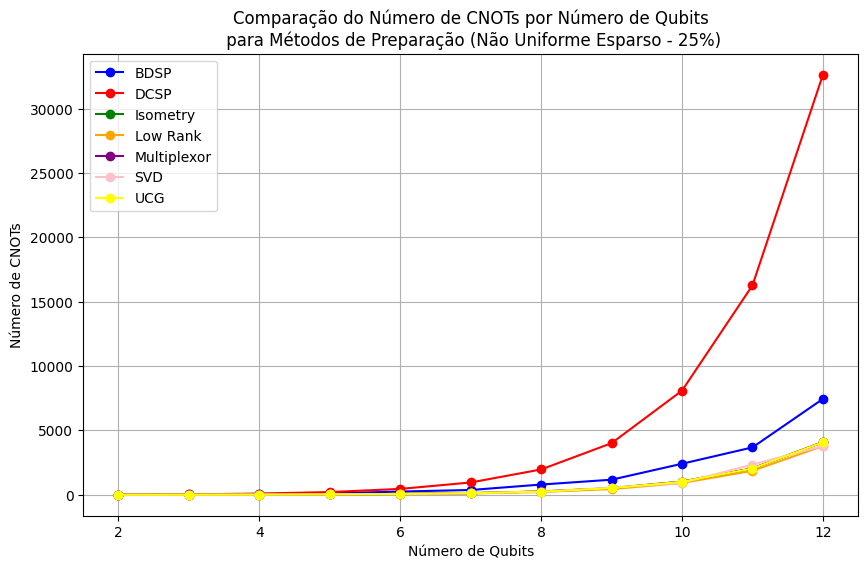

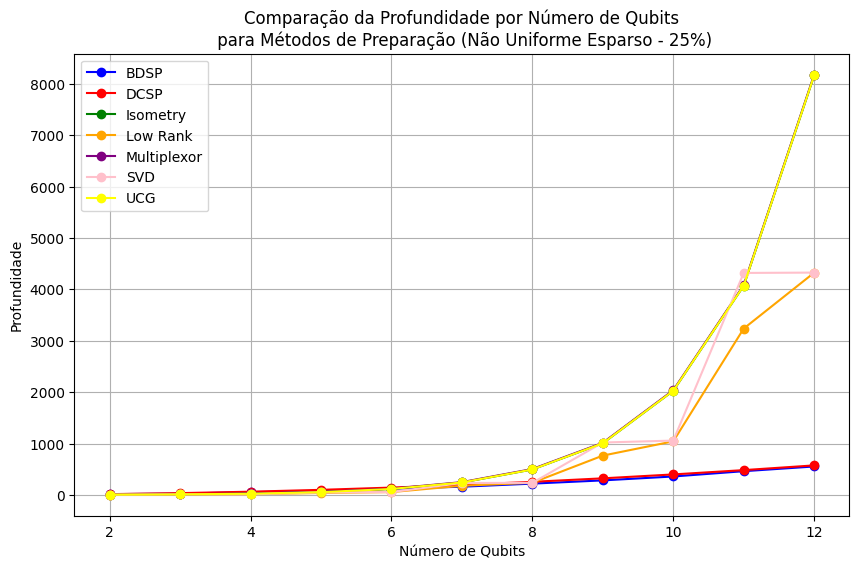

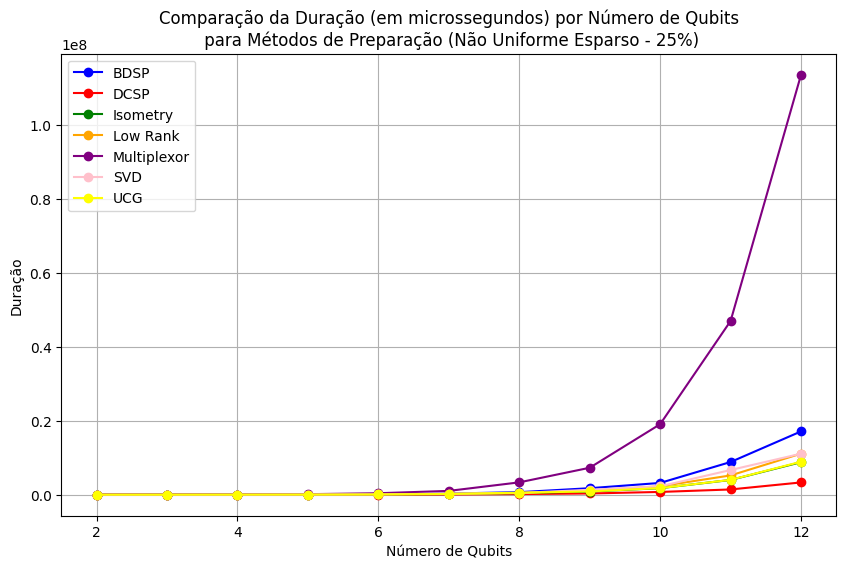

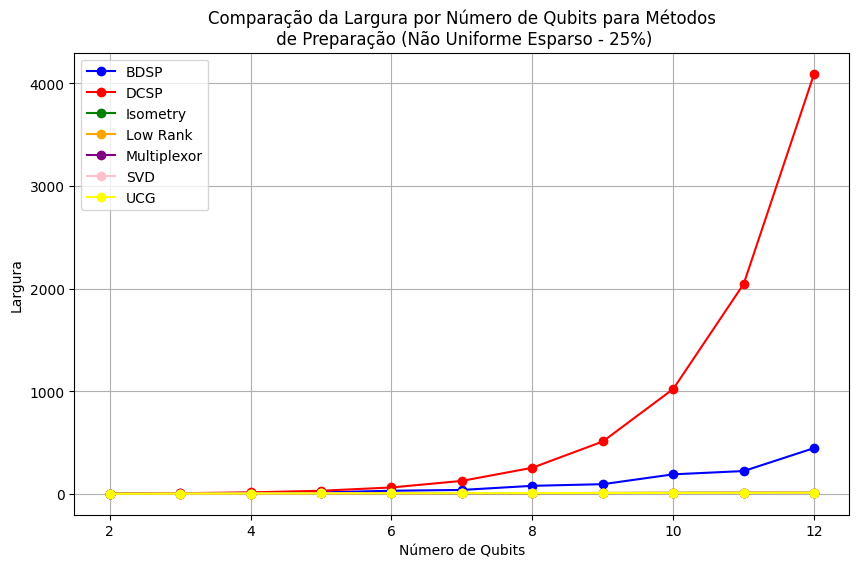

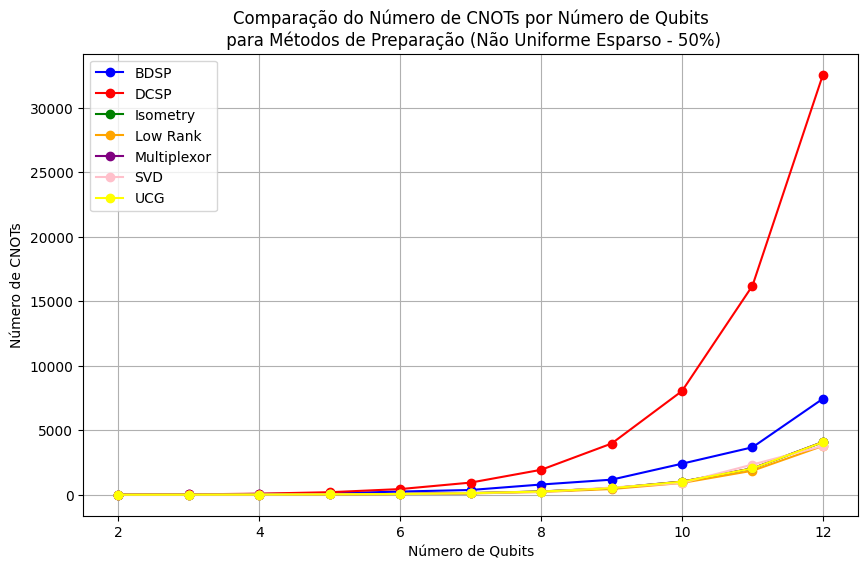

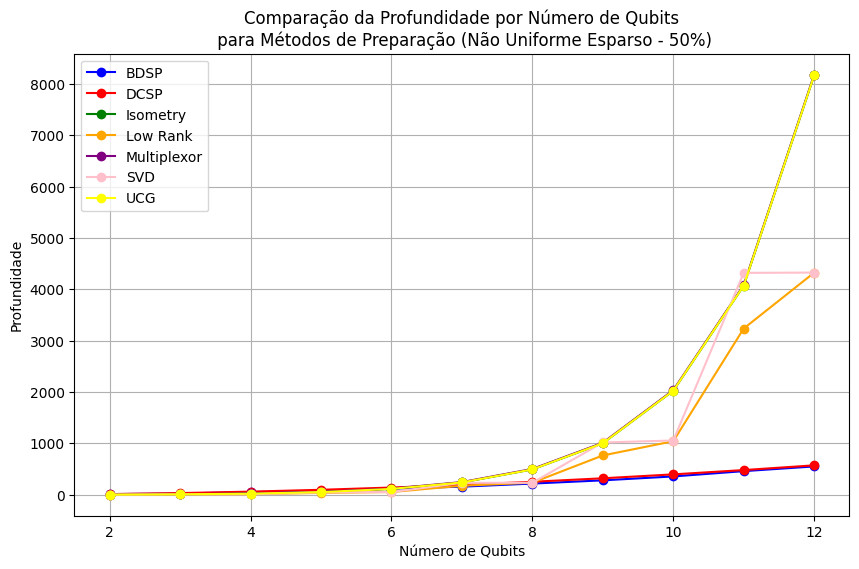

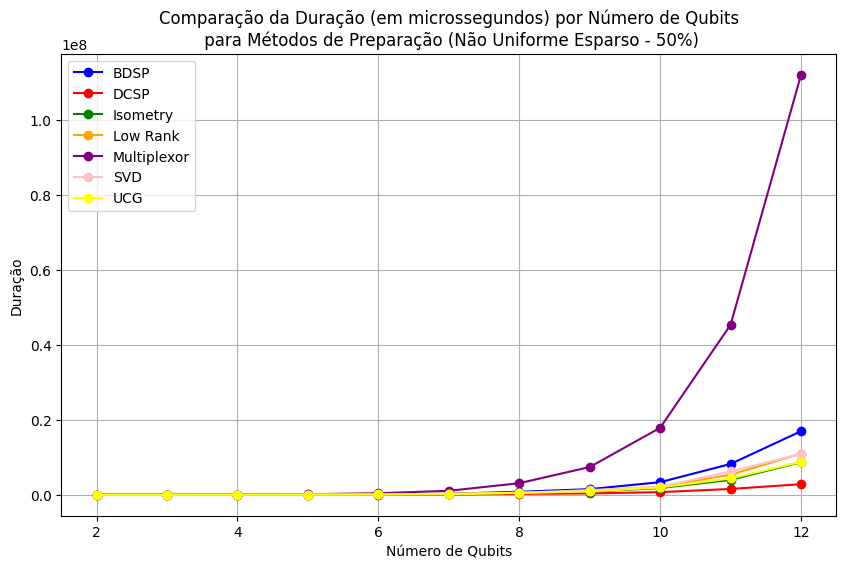

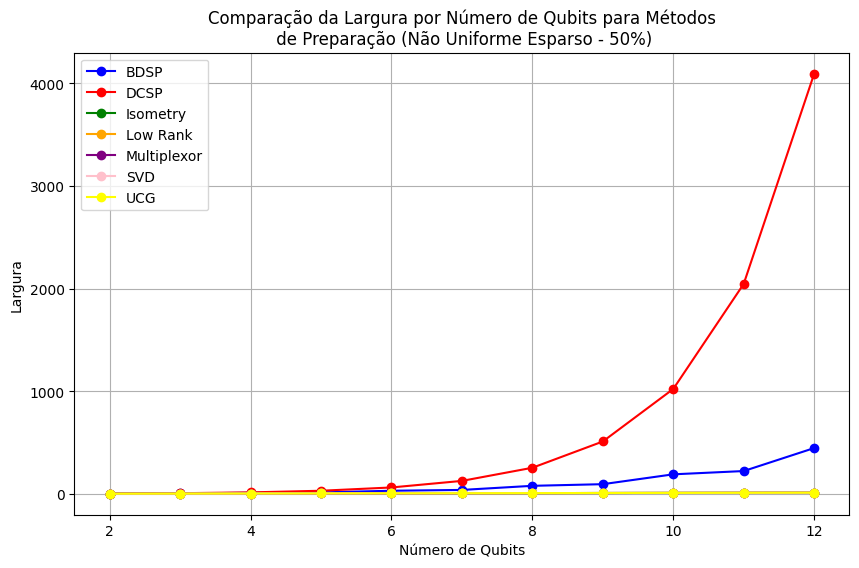

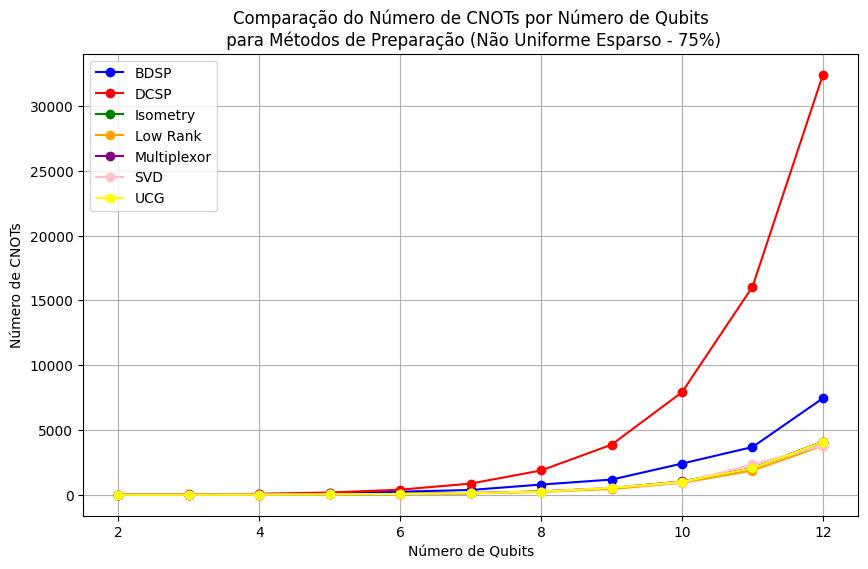

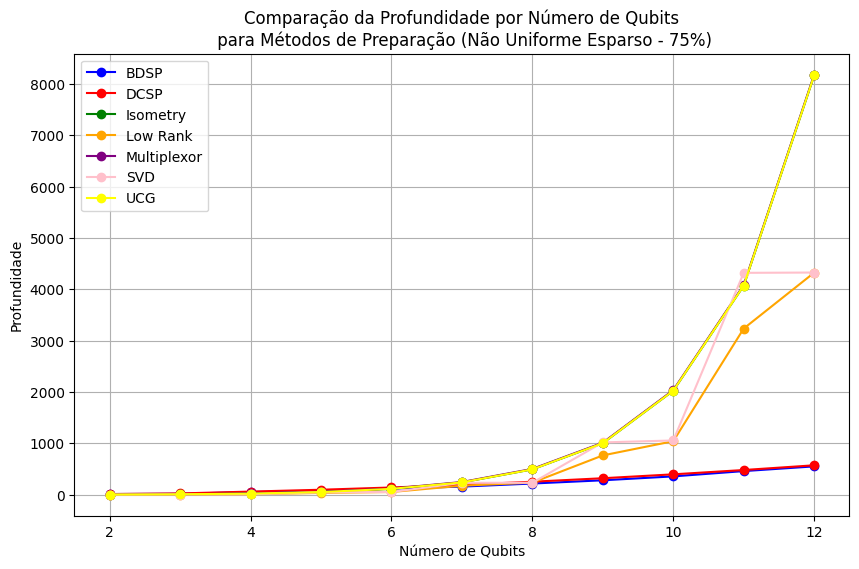

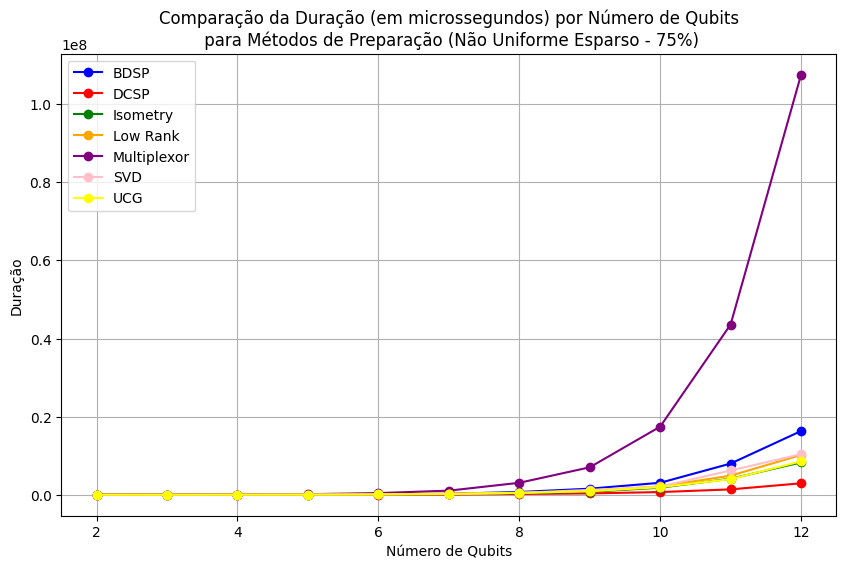

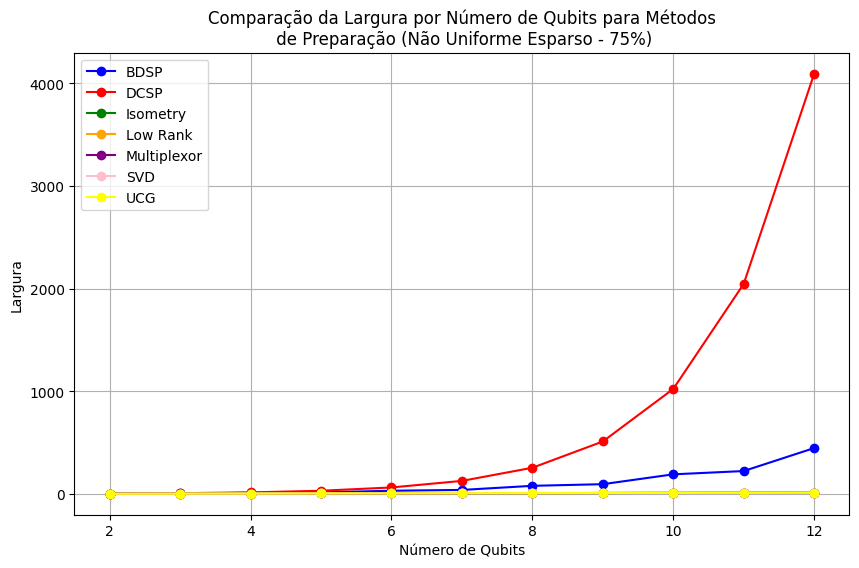

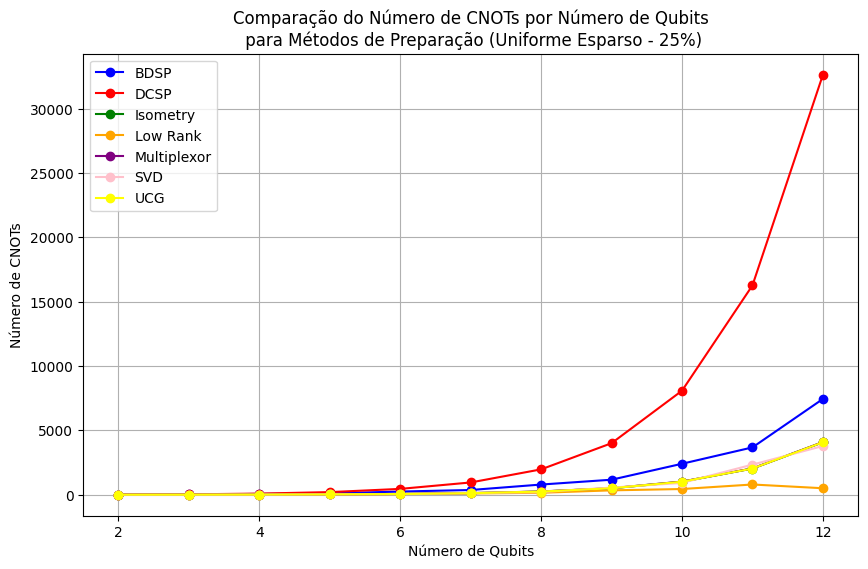

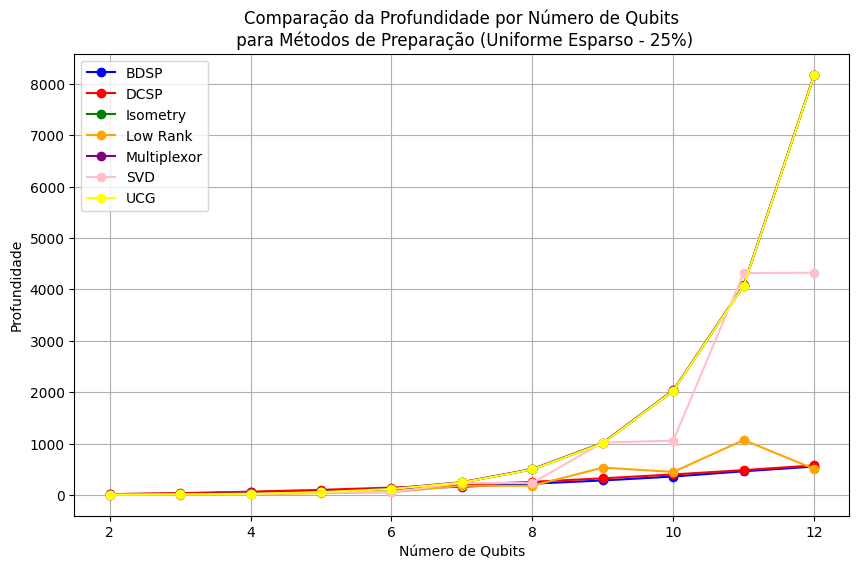

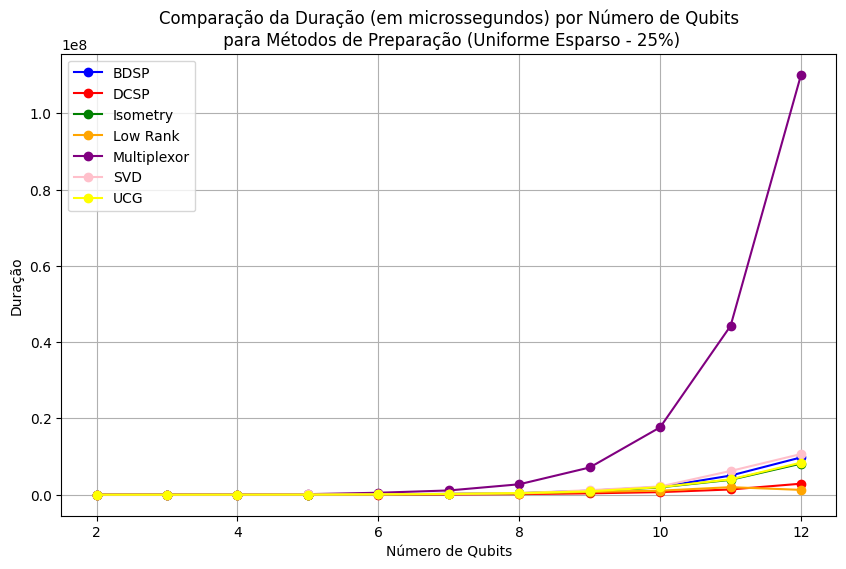

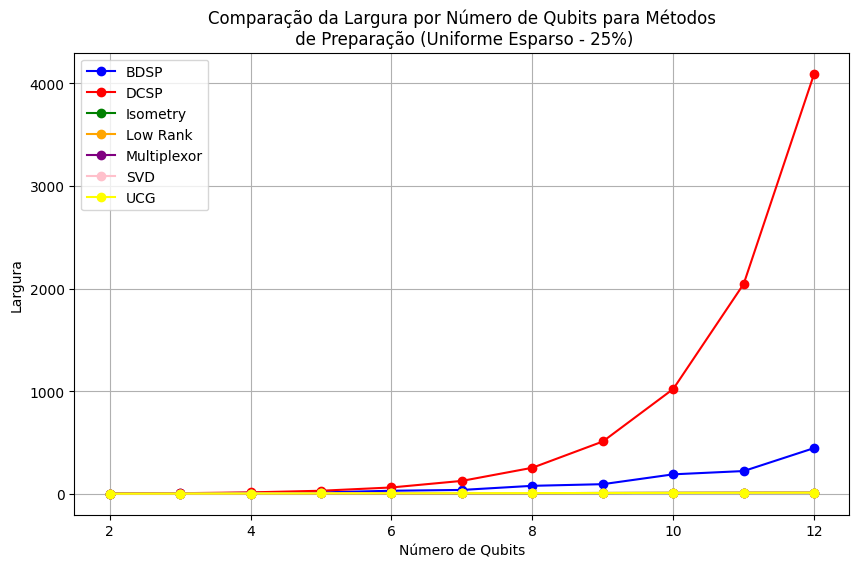

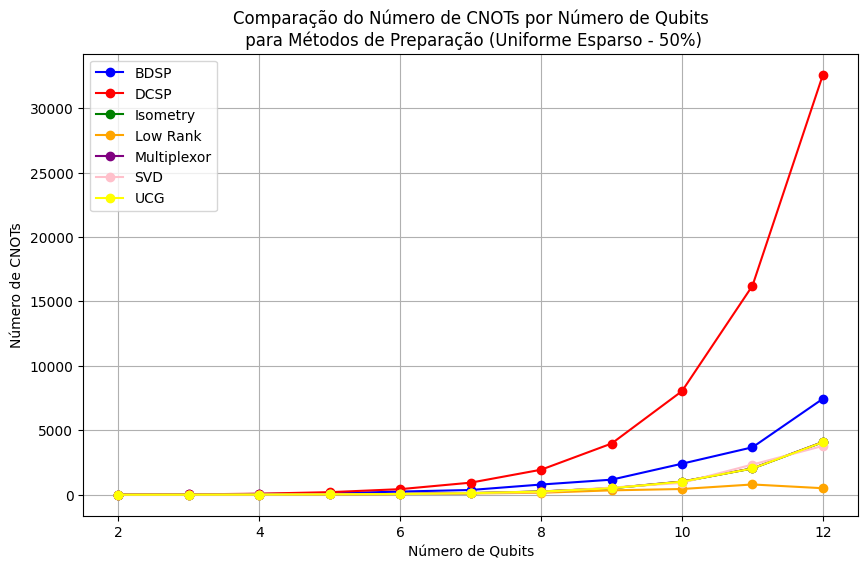

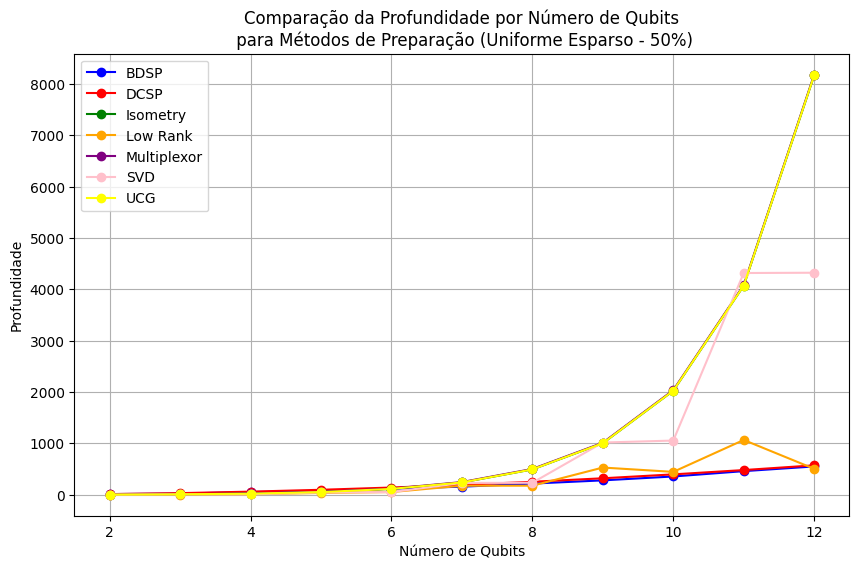

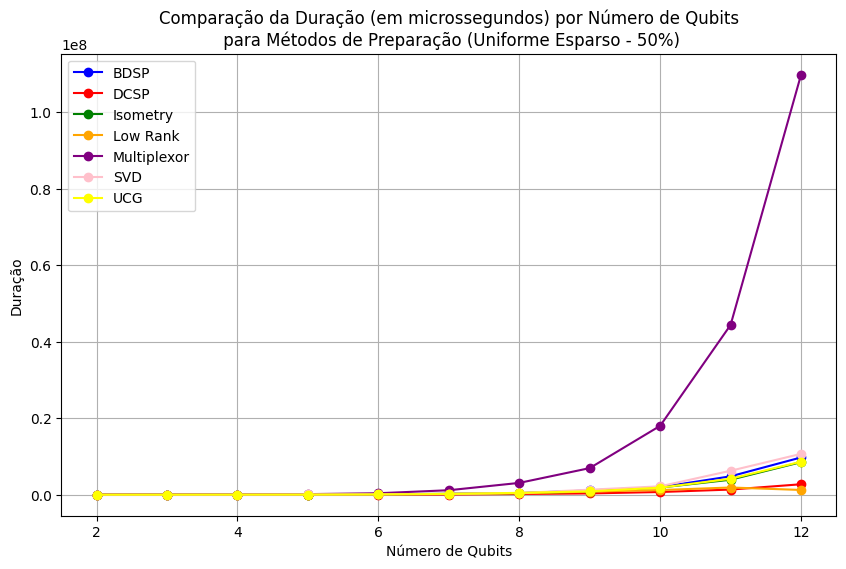

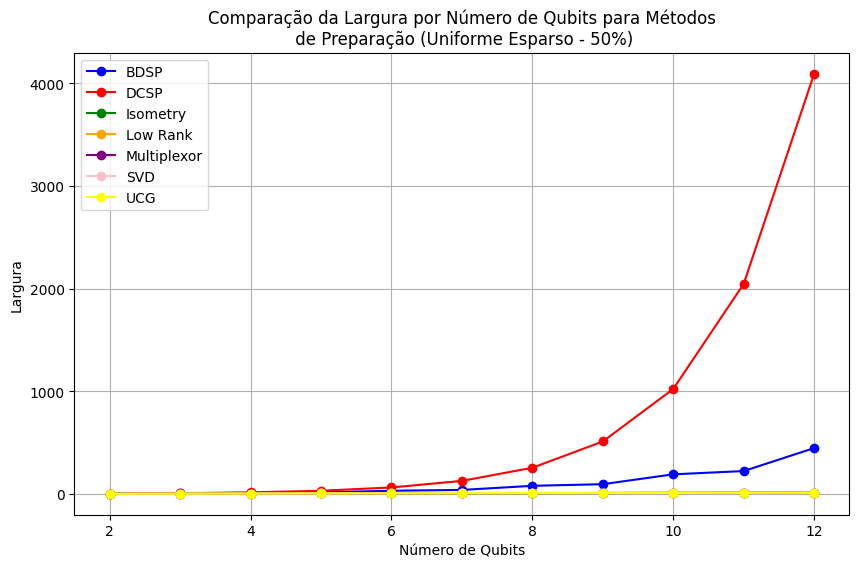

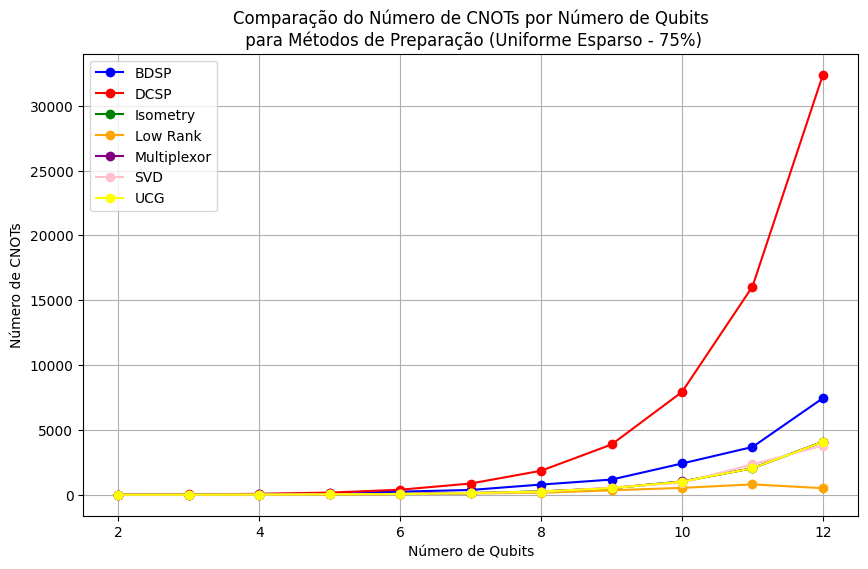

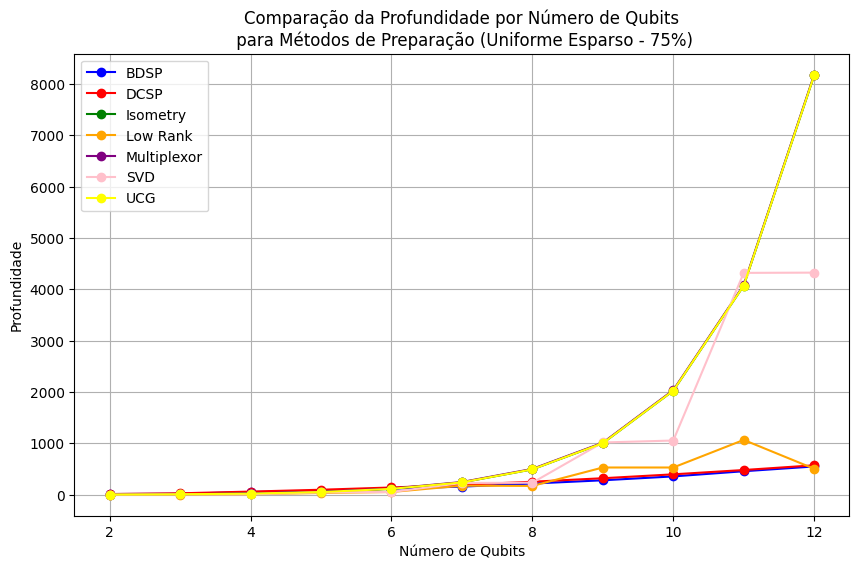

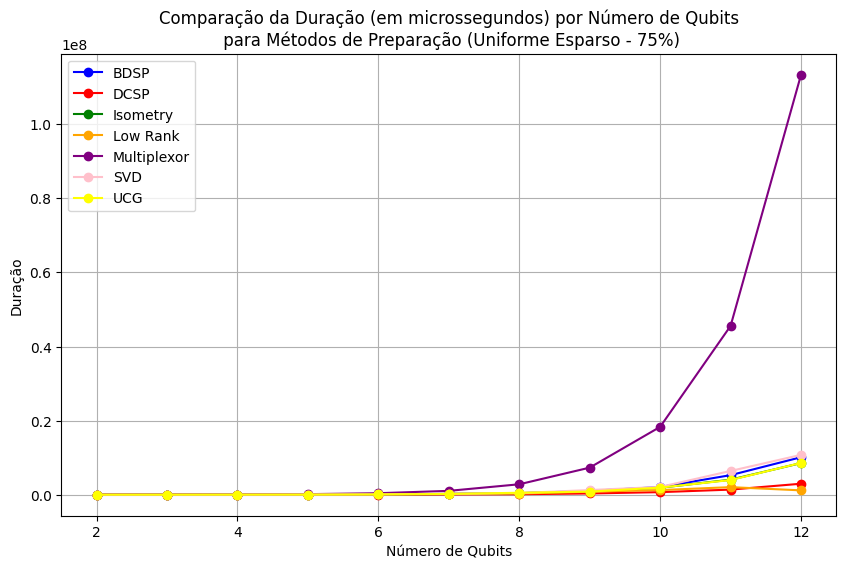

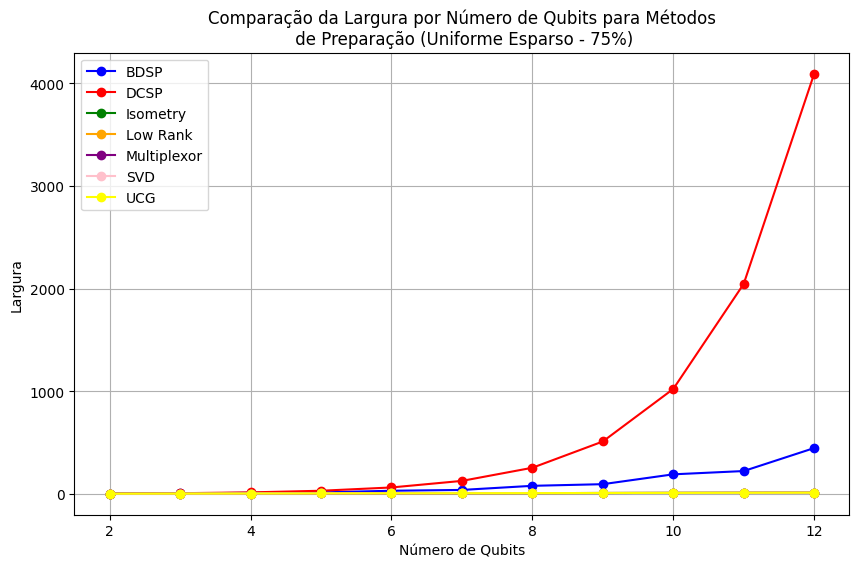

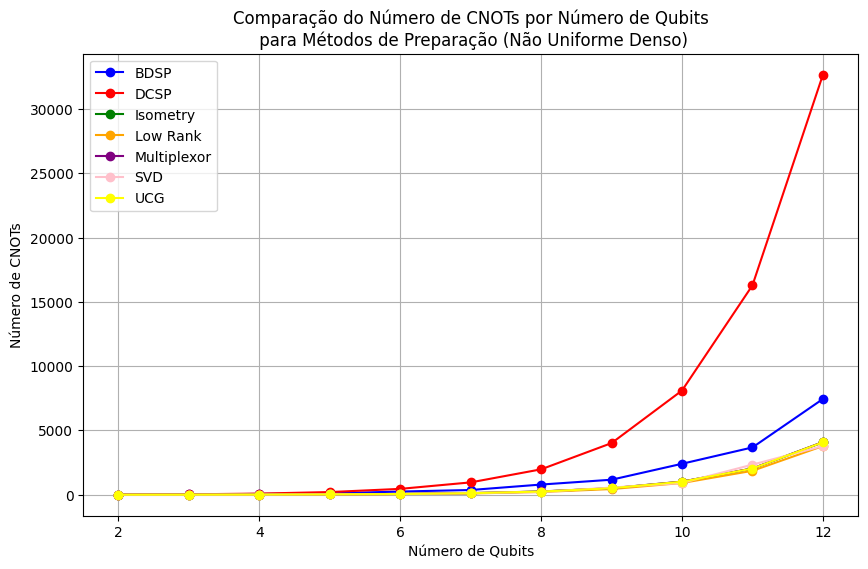

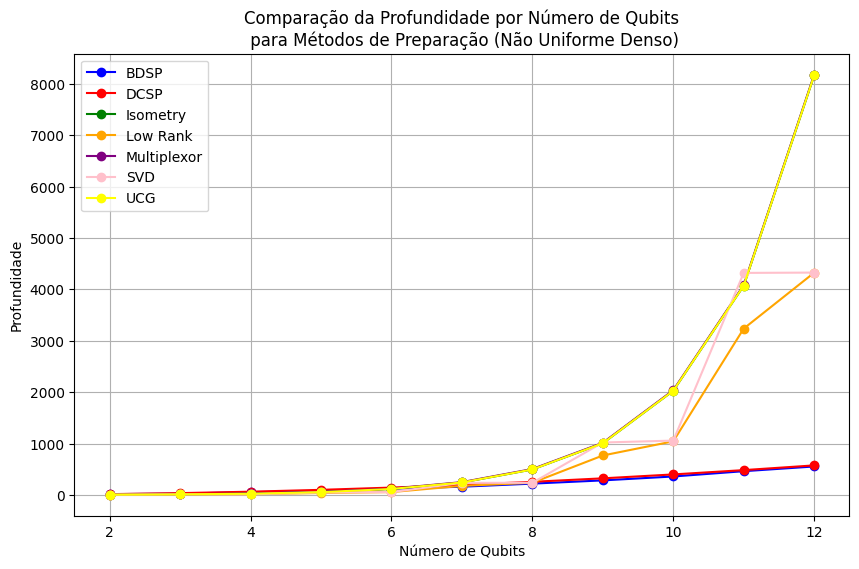

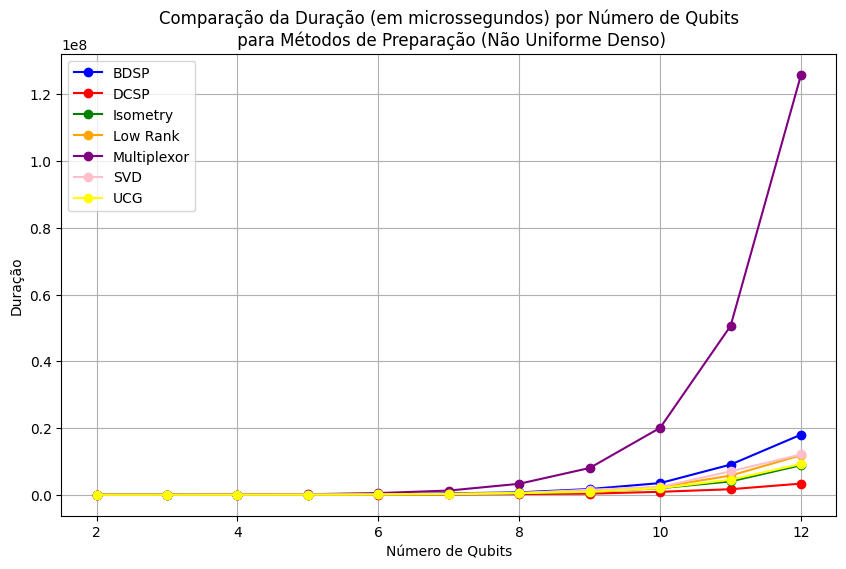

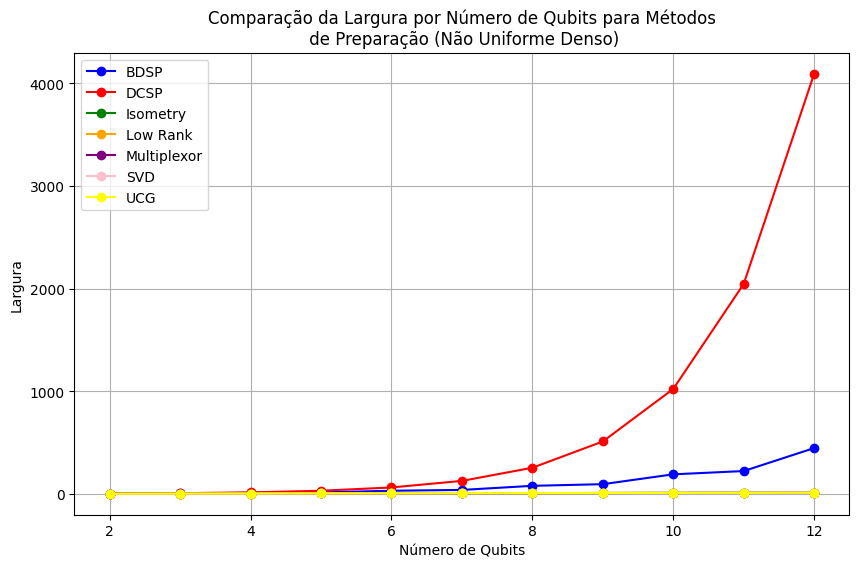

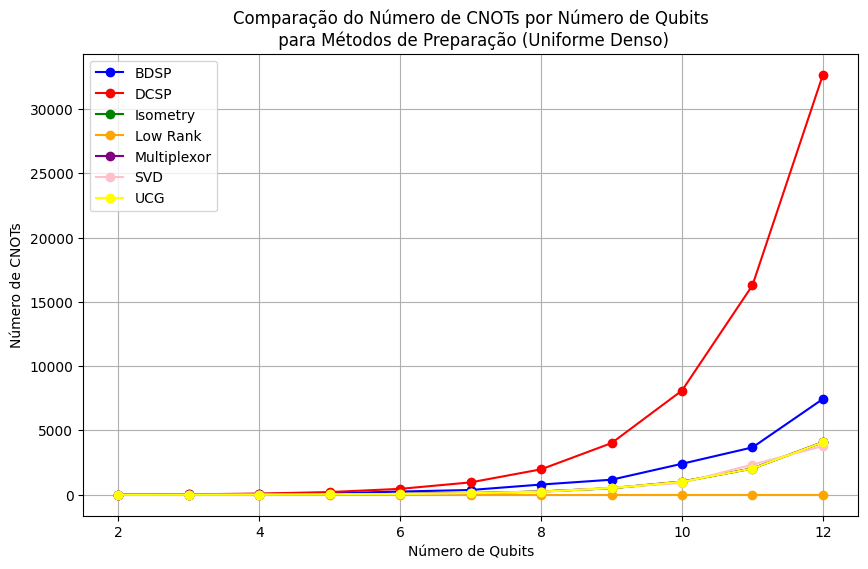

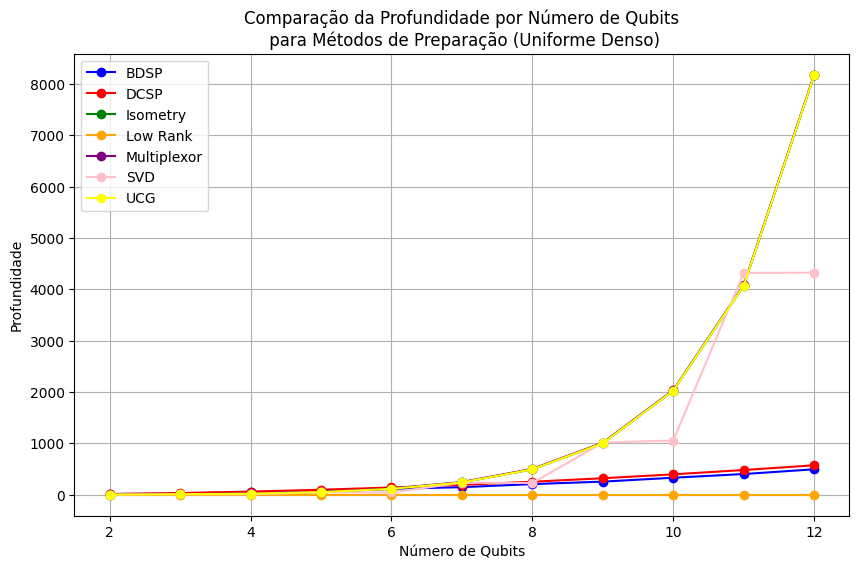

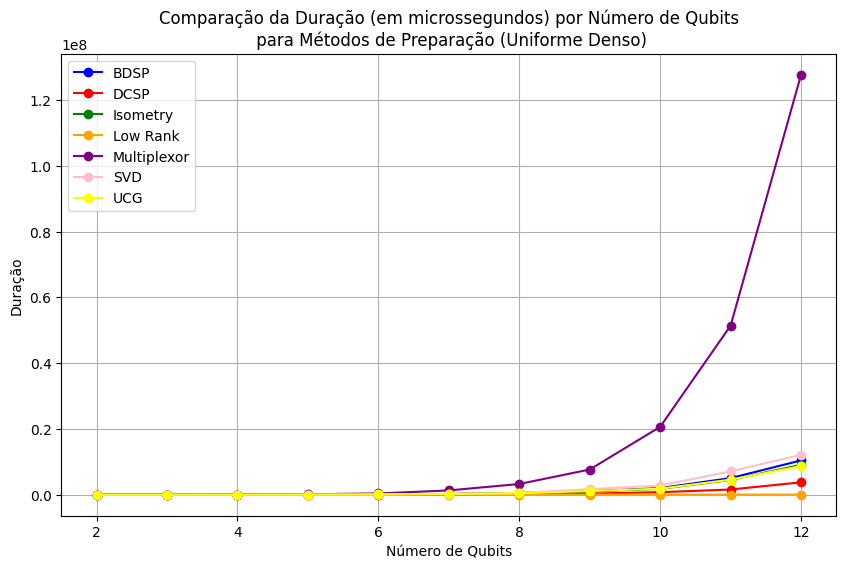

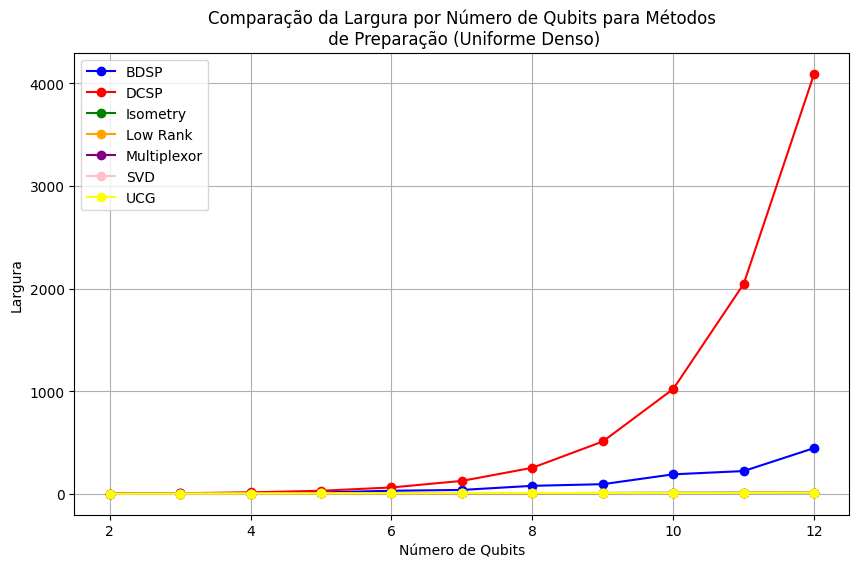

In [ ]:
for df in dfs:
#df_00_25, df_00_50, df_00_75, df_10_25, df_10_50, df_10_75, df_01, df_11, df_full
  gerarFigs(df)
#gerarFigs(df_full)

In [ ]:
# Salvar o DataFrame como um arquivo CSV
merged_df.to_csv('merged_data.csv', index=False)

# Baixar o arquivo CSV
files.download('merged_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Download

In [ ]:
# Salvar todas as figuras em PDF
for i, fig in enumerate(figuras, 1):
    fig_path = os.path.join(temp_dir, f"figura_{i}.pdf")
    fig.savefig(fig_path)
    plt.close(fig)  # Fechar a figura após salvar para liberar memória

# Compactar todos os arquivos em um arquivo ZIP
shutil.make_archive("./graficosDeLinha", 'zip', temp_dir)

# Baixar o arquivo ZIP
files.download("./graficosDeLinha.zip")

# Excluir o diretório temporário
shutil.rmtree(temp_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>